In [1]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from scipy.optimize import minimize, line_search

In [2]:
def random():
    np.random.seed(0)
    return np.random.uniform(-1, 1)
random()

0.0976270078546495

In [3]:
def f_no_noise(x1, x2):
    a = x1 + 0.1
    b = x2 - np.sin(3*x1)

    return 3.89*(a**2) + 5.4*a*b + 2*(b**2)

def f(x1, x2):
    a = x1 + 0.1
    b = x2 - np.sin(3*x1)
    np.random.seed((x1+x2).mean().astype(np.int64))
    eps = np.random.uniform(-1, 1, a.shape)
    # eps = 0

    return 3.89*(a**2) + 5.4*a*b + 2*(b**2) + eps

def f_k(x):
    A = np.array([[1, 1], [1.7, 1]])
    x1 = x[0]
    x2 = x[1]
    x = np.array([x1 + 0.1, x2 - np.sin(3*x1)]).T
    
    np.random.seed(int(x1+x2))
    eps = np.random.uniform(-1, 1)
    # eps = 0
    
    return x.T @ A.T @ A @ x + eps

def nabla_f(x):
    A = np.array([[1, 1], [1.7, 1]])
    x1 = x[0]
    x2 = x[1]
    x = np.array([x1 + 0.1, x2 - np.sin(3*x1)]).T
    D = np.array([[1, -3*np.cos(3*x1)], [0, 1]])

    np.random.seed(int(x1 + x2))
    eps = np.random.uniform(-1, 1)
    eps = 0

    return D @ A.T @ A @ x + eps

def get_B(x):
    B = [[0, 0], [0, 0]]
    h = 10e-8
    for i in range(2):
        for j in range(2):
            B[i][j] = (nabla_f((x + h*np.eye(1, 2, j))[0].T)[i] - nabla_f(x)[i])/h
    B = np.array(B)
    return B

def cauchy(delta, B, g):
    # delta = trust region, g = nabla f_k
    g_norm = np.linalg.norm(g)

    if g.T @ B @ g <= 0:
        tau = 1
    else:
        tau = min((g_norm**3)/(delta * g.T @ B @ g), 1)
    
    return -tau * (delta / g_norm)*g

def m(p, f, g, B):
    # f = f_k, g = nabla f_k, B approx nabla^2 f_k
    return f + (g.T @ p) + 0.5*(p.T @ B @ p)

def trust_region(delta_0, method='tr', r=8):
    eta = 1/6
    delta_hat = 3
    delta = delta_0
    eps_f = 1
    x = np.array([1, 1]).T
    xs = [x]
    deltas = [delta]
    fvals = []
    grad_norms = []
    rhos = []

    for k in range(100):
        f_val = f_k(x)
        fvals += [f_val]

        g = nabla_f(x)
        grad_norms += [np.linalg.norm(g)]
        
        B = get_B(x)
        p = cauchy(delta, B, g)
        A = np.array([[1, 1], [1.7, 1]])
        if method == 'tr':
            rho = (f_val - f_k(x+p))/(m(np.zeros(2), f_val, g, B) - m(p, f_val, g, B))
        else: # noisy method
            rho = (f_val - f_k(x+p) + r*eps_f)/(m(np.zeros(2), f_val, g, B) - m(p, f_val, g, B) + r*eps_f) 
        
        rhos += [rho]
        
        if rho < 0.25:
            delta = 0.25*delta
        elif (rho > 0.75) and (np.linalg.norm(p) == delta):
                delta = min(2*delta, delta_hat)

        if rho > eta:
            x = x + p
        
        xs += [x]
        deltas += [delta]

    x1s = [x[0] for x in xs]
    x2s = [x[1] for x in xs]

    print('x_100 =', x)
    print('nabla f_100 =', nabla_f(x))

    xlist = np.linspace(-2, 3, 100)
    ylist = np.linspace(-2, 2, 100)
    X, Y = np.meshgrid(xlist, ylist)
    Z = f(X, Y)

    fig, ax = plt.subplots()
    ax.contour(X, Y, Z, levels=20, colors='black')
    ax.plot(x1s, x2s, color='blue') # plot steps

    # plot trust regions
    for i in range(len(xs)):
        cir = plt.Circle((x1s[i], x2s[i]), deltas[i], color='red',fill=False)
        ax.add_patch(cir)

    plt.show()
    
    return fvals, grad_norms, rhos, deltas


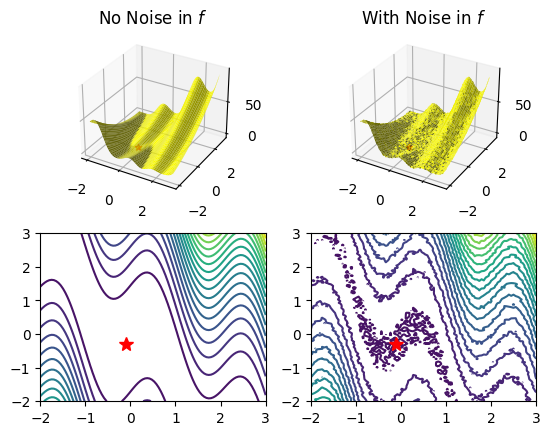

In [9]:
xlist = np.linspace(-2, 3, 100)
ylist = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(xlist, ylist)
Z_no_noise = f_no_noise(X, Y)
Z = f(X, Y)

fig = plt.figure()

ax = fig.add_subplot(2,2,1, projection='3d')
ax.scatter(-0.1, -0.29552021, f_k(np.array([-0.1, -0.3])), color='red', marker='*')
ax.plot_surface(X, Y, Z_no_noise, color='yellow')
ax.set_title('No Noise in $f$')

ax = fig.add_subplot(2,2,2, projection='3d')
ax.scatter(-0.1, -0.29552021, f_k(np.array([-0.1, -0.3])), color='red', marker='*')
ax.plot_surface(X, Y, Z, color='yellow')
ax.set_title('With Noise in $f$')

ax = fig.add_subplot(2,2,3)
ax.contour(X, Y, Z_no_noise, levels=20)
ax.plot(-0.1, -0.29552021, color='red', marker='*', markersize=10)

ax = fig.add_subplot(2,2,4)
ax.contour(X, Y, Z, levels=20)
ax.plot(-0.1, -0.29552021, color='red', marker='*', markersize=10)

Classical TR Method:
x_100 = [-0.10000001 -0.29552022]
nabla f_100 = [-4.98432012e-10 -1.03373826e-09]


C:\Users\anind\AppData\Local\Temp\ipykernel_25948\2933611880.py:88: RuntimeWarning: divide by zero encountered in double_scalars
  rho = (f_val - f_k(x+p))/(m(np.zeros(2), f_val, g, B) - m(p, f_val, g, B))
C:\Users\anind\AppData\Local\Temp\ipykernel_25948\2933611880.py:88: RuntimeWarning: invalid value encountered in double_scalars
  rho = (f_val - f_k(x+p))/(m(np.zeros(2), f_val, g, B) - m(p, f_val, g, B))


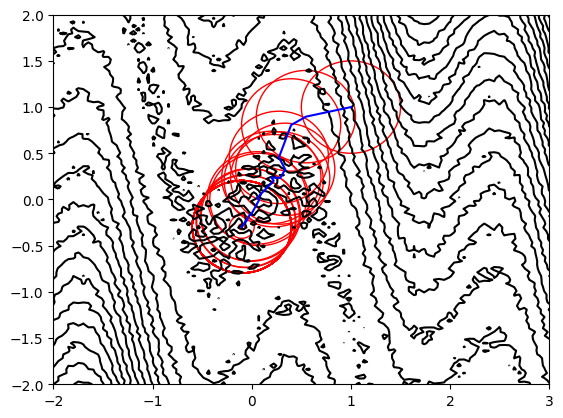

Noisy TR Method:
x_100 = [-0.1        -0.29552021]
nabla f_100 = [-1.11924167e-14  5.30825384e-15]


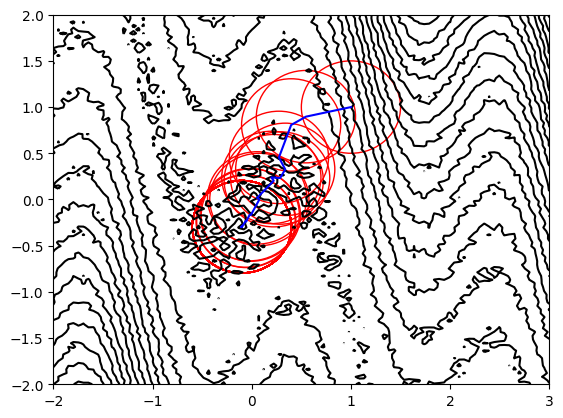

In [29]:
print('Classical TR Method:')
fvals_tr, norms_tr, rhos_tr, deltas_tr = trust_region(0.5)

print('Noisy TR Method:')
fvals_ntr, norms_ntr, rhos_ntr, deltas_ntr = trust_region(0.5, method='noisy')

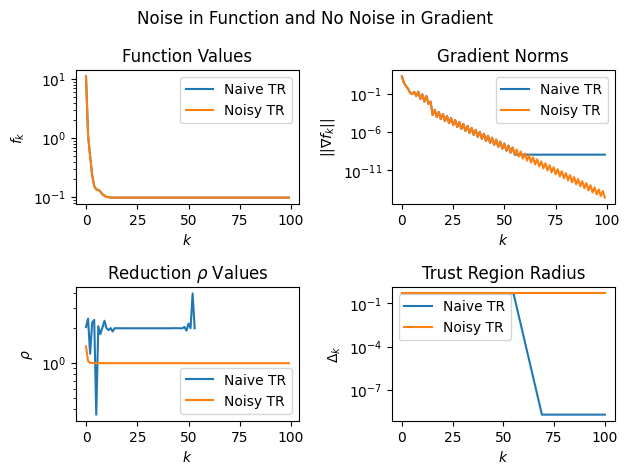

In [30]:
fig, ax = plt.subplots(2,2)
# fig.suptitle('No Noise in Both Function and Gradient')
fig.suptitle('Noise in Function and No Noise in Gradient')
# fig.suptitle('No Noise in Function and Noise in Gradient')
# fig.suptitle('Noise in Both Function and Gradient')

ks = [k for k in range(100)]

ax[0,0].semilogy(ks, fvals_tr, label='Naive TR')
ax[0,0].semilogy(ks, fvals_ntr, label='Noisy TR')
ax[0,0].title.set_text('Function Values')
ax[0,0].set_xlabel('$k$')
ax[0,0].set_ylabel('$f_k$')
ax[0,0].legend()

ax[0,1].semilogy(ks, norms_tr, label='Naive TR')
ax[0,1].semilogy(ks, norms_ntr, label='Noisy TR')
ax[0,1].title.set_text('Gradient Norms')
ax[0,1].set_xlabel('$k$')
ax[0,1].set_ylabel('$||\\nabla f_k||$')
ax[0,1].legend()

ax[1,0].semilogy(ks, rhos_tr, label='Naive TR')
ax[1,0].semilogy(ks, rhos_ntr, label='Noisy TR')
ax[1,0].title.set_text('Reduction $\\rho$ Values')
ax[1,0].set_xlabel('$k$')
ax[1,0].set_ylabel('$\\rho$')
ax[1,0].legend(loc=4)

ks = [k for k in range(101)]
ax[1,1].semilogy(ks, deltas_tr, label='Naive TR')
ax[1,1].semilogy(ks, deltas_ntr, label='Noisy TR')
ax[1,1].title.set_text('Trust Region Radius')
ax[1,1].set_xlabel('$k$')
ax[1,1].set_ylabel('$\\Delta_k$')
ax[1,1].legend()

fig.tight_layout()

plt.show()

In [172]:
# BFGS Method with Errors

def f(x):
    A = np.array([[1, 1], [1.7, 1]])
    x1 = x[0]
    x2 = x[1]
    x = np.array([x1 + 0.1, x2 - np.sin(3*x1)]).T
    np.random.seed(abs(int(x1+x2)))
    eps = np.random.uniform(-1, 1)
    # eps = 0
    
    return x.T @ A.T @ A @ x + eps

def nabla_f(x):
    A = np.array([[1, 1], [1.7, 1]])
    x1 = x[0]
    x2 = x[1]
    x = np.array([x1 + 0.1, x2 - np.sin(3*x1)]).T
    D = np.array([[1, -3*np.cos(3*x1)], [0, 1]])

    np.random.seed(abs(int(x1+x2)))
    eps = np.random.uniform(-1, 1)
    # eps = 0

    return D @ A.T @ A @ x + eps

tol = 10**(-2)
maxiter = 100

l  = 1

x = np.array([1,1]).T

f_k = f(x)
df_x0 = nabla_f(x)

I = np.eye(2)
H = I

for k in range(maxiter):
    if np.linalg.norm(df_x0) < tol:
        break

    p = -H @ df_x0
    alpha_star,_,_,_,_,new_slope = line_search(f=f, myfprime=nabla_f, xk=x, pk=p, gfk=df_x0, old_fval=f_k, c1=0.1, c2=0.8, amax=1)
    
    if np.all(new_slope) != None:
        # print('LS succeeded')
        alpha = alpha_star
    else:
        # print('LS failed')
        alpha = 0
    
    if np.linalg.norm(alpha*p) >= l:
        s = alpha*p
        y = nabla_f(x + s) - nabla_f(x)
    else:
        s = l*(p/np.linalg.norm(p))
        y = nabla_f(x + s) - nabla_f(x)

    rho = 1/(s.T @ y)
    H = (I - rho * s @ y.T) @ H @ (I - rho * y @ s.T) + rho * s @ s.T

    x = x + alpha*p

    f_k = f(x)
    df_x0 = nabla_f(x)

print('x_100 =', x)
print('nabla f_100 =',nabla_f(x))

x_100 = [-0.87492803  0.57130702]
nabla f_100 = [0.06025687 0.13615138]
